In [12]:
import os
import pandas as pd
from modules.util import numerical_to_float
from soil.soil import fill_thermal_conductivity, compute_soil_heatflux
import matplotlib.pyplot as plt


df1 = pd.read_csv('data/data_files/BG_meteo_30min_20230101_20230801.csv', sep=',', na_values=['NaN']).drop(0) # BG meteo 2023
df2 = pd.read_csv('data/data_files/GW_meteo_30min_20230101_20230801.csv', sep=',', na_values=['NaN']).drop(0) # GW meteo 2023
df3 = pd.read_csv('data/data_files/BG_meteo_30min_20240401_20240608.csv', sep=';', na_values=['NaN']).drop(0) # BG meteo 2024
df4 = pd.read_csv('data/data_files/GW_meteo_30min_20240401_20240608.csv', sep=';', na_values=['NaN']).drop(0) # GW meteo 2024

df1 = df1.drop(["TIMESTAMP_MITTE", "TIMESTAMP_ENDE"], axis=1)
df2 = df2.drop(["TIMESTAMP_MITTE", "TIMESTAMP_ENDE"], axis=1)
df3 = df3.drop(["TIMESTAMP_MITTE", "TIMESTAMP_ENDE"], axis=1)
df4 = df4.drop(["TIMESTAMP_MITTE", "TIMESTAMP_ENDE"], axis=1)

In [13]:
print(df1.columns)
print(df2.columns)
print(df3.columns)
print(df4.columns)

Index(['TIMESTAMP_START', 'kurzwEinstrahlung_300cm', 'kurzwAusstrahlung_300cm',
       'Nettostrahlung_300cm', 'diffuseEinstrahlung_160cm',
       'PPFDEinstrahlung_300cm', 'PPFDAusstrahlung_300cm', 'Bodenwaermefluss',
       'Luftdruck', 'Lufttemperatur_40cm', 'Lufttemperatur_200cm',
       'RelativeFeuchte_40cm', 'RelativeFeuchte_200cm',
       'Wasserdampfdruck_200cm', 'Wasserdampfdefizit_200cm',
       'Niederschlag_I_155cm', 'Niederschlag_II_150cm', 'Windgeschw_380cm',
       'Windrichtung_380cm', 'Bodentemp_30cm_1', 'Bodentemp_30cm_2',
       'Bodentemp_30cm_3', 'Bodenfeuchte_30cm_1', 'Bodenfeuchte_30cm_2',
       'Bodenfeuchte_30cm_3'],
      dtype='object')
Index(['TIMESTAMP_START', 'kurzwEinstrahlung_43m', 'kurzwAusstrahlun_43m',
       'langwEinstrahlung_43m', 'langwAusstrahlung_43m', 'Luftdruck_43m',
       'Lufttemperatur_43m', 'RelativeFeuchte_43m', 'Wasserdampfdruck_43m',
       'Wasserdampfdefizit_43m', 'Niederschlag_43m', 'Windgeschw_I_43m',
       'Windgeschw_II_43m', 

Change column names to english and make them consistent.

In [14]:
# fix spelling error in df2
df2["kurzwAusstrahlung_43m"] = df2["kurzwAusstrahlun_43m"]
df2 = df2.drop("kurzwAusstrahlun_43m", axis=1)

# convert relevant columns to float
df1_cols = ["Bodenwaermefluss", "kurzwEinstrahlung_300cm", "kurzwAusstrahlung_300cm",
            "Wasserdampfdefizit_200cm", "Wasserdampfdruck_200cm", "RelativeFeuchte_200cm", "Windgeschw_380cm", "Luftdruck"]
df2_cols = [f"Bodentemp_{idx}_{depth}cm" for idx in [1, 2, 3] for depth in [5, 15, 30]]
df2_cols.extend(["kurzwEinstrahlung_43m", "kurzwAusstrahlung_43m", "Luftdruck_43m",
                 "Wasserdampfdefizit_43m", "Wasserdampfdruck_43m", "RelativeFeuchte_43m", "Windgeschw_I_43m"])

df3_cols = df1_cols.copy()
df4_cols = df2_cols.copy()
# add soil moisture
df4_cols.extend([f"Bodenfeuchte_{idx}_{depth}cm" for idx in [1, 2, 3] for depth in [5, 15, 30]])


df1 = numerical_to_float(df1, df1_cols)
df2 = numerical_to_float(df2, df2_cols)
df3 = numerical_to_float(df3, df3_cols)
df4 = numerical_to_float(df4, df4_cols)




df1["incomingShortwaveRadiation"] = df1["kurzwEinstrahlung_300cm"]
df2["incomingShortwaveRadiation"] = df2["kurzwEinstrahlung_43m"]
df3["incomingShortwaveRadiation"] = df3["kurzwEinstrahlung_300cm"]
df4["incomingShortwaveRadiation"] = df4["kurzwEinstrahlung_43m"]

df1["outgoingShortwaveRadiation"] = df1["kurzwAusstrahlung_300cm"]
df2["outgoingShortwaveRadiation"] = df2["kurzwAusstrahlung_43m"]
df3["outgoingShortwaveRadiation"] = df3["kurzwAusstrahlung_300cm"]
df4["outgoingShortwaveRadiation"] = df4["kurzwAusstrahlung_43m"]


for idx in [1, 2, 3]:
    for depth in [5, 15, 30]:
        df2[f"soilTemperature_{idx}_{depth}cm"] = df2[f"Bodentemp_{idx}_{depth}cm"]
        df4[f"soilTemperature_{idx}_{depth}cm"] = df4[f"Bodentemp_{idx}_{depth}cm"]
        df4[f"soilMoisture_{idx}_{depth}cm"] = df4[f"Bodenfeuchte_{idx}_{depth}cm"]


# compute soil heatflux for df4 and df2
df4 = fill_thermal_conductivity(df4)
df4 = compute_soil_heatflux(df4)

for idx in [1, 2, 3]:
    # just use mean thermal conductivity here
    df2[f"thermalConductivity_{idx}_5cm"] = df4[f"thermalConductivity_{idx}_5cm"].mean()

df2 = compute_soil_heatflux(df2)
df1["soilHeatflux"] = df1["Bodenwaermefluss"]
df3["soilHeatflux"] = df3["Bodenwaermefluss"]

df1["airPressure"] = df1["Luftdruck"]
df2["airPressure"] = df2["Luftdruck_43m"]
df3["airPressure"] = df3["Luftdruck"]
df4["airPressure"] = df4["Luftdruck_43m"]

df1["waterPressureDeficit"] = df1["Wasserdampfdefizit_200cm"]
df2["waterPressureDeficit"] = df2["Wasserdampfdefizit_43m"]
df3["waterPressureDeficit"] = df3["Wasserdampfdefizit_200cm"]
df4["waterPressureDeficit"] = df4["Wasserdampfdefizit_43m"]

df1["waterVaporPressure"] = df1["Wasserdampfdruck_200cm"]
df2["waterVaporPressure"] = df2["Wasserdampfdruck_43m"]
df3["waterVaporPressure"] = df3["Wasserdampfdruck_200cm"]
df4["waterVaporPressure"] = df4["Wasserdampfdruck_43m"]

df1["relativeHumidity"] = df1["RelativeFeuchte_200cm"]
df2["relativeHumidity"] = df2["RelativeFeuchte_43m"]
df3["relativeHumidity"] = df3["RelativeFeuchte_200cm"]
df4["relativeHumidity"] = df4["RelativeFeuchte_43m"]

df1["windSpeed"] = df1["Windgeschw_380cm"]
df2["windSpeed"] = df2["Windgeschw_I_43m"]
df3["windSpeed"] = df3["Windgeschw_380cm"]
df4["windSpeed"] = df4["Windgeschw_I_43m"]


cols = ["TIMESTAMP_START", "incomingShortwaveRadiation", "outgoingShortwaveRadiation",
        "soilHeatflux", "airPressure", "waterPressureDeficit", "waterVaporPressure", "relativeHumidity", "windSpeed"]

df1 = df1[cols]
df2 = df2[cols]
df3 = df3[cols]
df4 = df4[cols]


In [15]:
# merge 2023 and 2024 data, respectively
df1["Location"] = 0
df2["Location"] = 1
df3["Location"] = 0
df4["Location"] = 1


# concat all dataframes
df = pd.concat([df1, df2, df3, df4])

# merge some cols
df.head()

,TIMESTAMP_START,incomingShortwaveRadiation,outgoingShortwaveRadiation,soilHeatflux,airPressure,waterPressureDeficit,waterVaporPressure,relativeHumidity,windSpeed,Location
1,2023-01-01 00:00:00,-3.695000,-0.092667,5.301667,984.325000,6.826310,9.721517,58.748000,2.980000,0
2,2023-01-01 00:30:00,-4.819000,-0.026667,5.039000,984.493333,6.667064,9.633030,59.098000,3.113000,0
3,2023-01-01 01:00:00,-4.449333,0.007667,4.445333,984.536667,6.568903,9.598582,59.369667,2.817000,0
4,2023-01-01 01:30:00,-3.713000,-0.130333,4.114000,984.500667,6.618655,9.577867,59.135333,2.737667,0
5,2023-01-01 02:00:00,-4.892000,0.062000,3.895000,984.518667,6.407977,9.491264,59.696333,2.594667,0


In [16]:
def nan_percentage(df):
    """
    Returns a DataFrame containing the percentage of NaN values in each column of the input DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    
    Returns:
    pd.DataFrame: A DataFrame with columns 'Column' and 'NaN_Percentage' showing the percentage of NaN values for each column.
    """
    # Calculate the percentage of NaN values for each column
    nan_percentage = df.isna().mean() * 100
    
    # Create a new DataFrame with the results
    nan_df = pd.DataFrame({
        'Column': nan_percentage.index,
        'NaN_Percentage': nan_percentage.values
    })
    
    return nan_df

In [17]:
df_nan = nan_percentage(df)
df_nan.head(15)

,Column,NaN_Percentage
0,TIMESTAMP_START,0.000000
1,incomingShortwaveRadiation,0.111607
2,outgoingShortwaveRadiation,0.111607
3,soilHeatflux,2.700893
4,airPressure,0.107887
5,waterPressureDeficit,4.531250
6,waterVaporPressure,4.531250
7,relativeHumidity,0.107887
8,windSpeed,0.792411
9,Location,0.000000


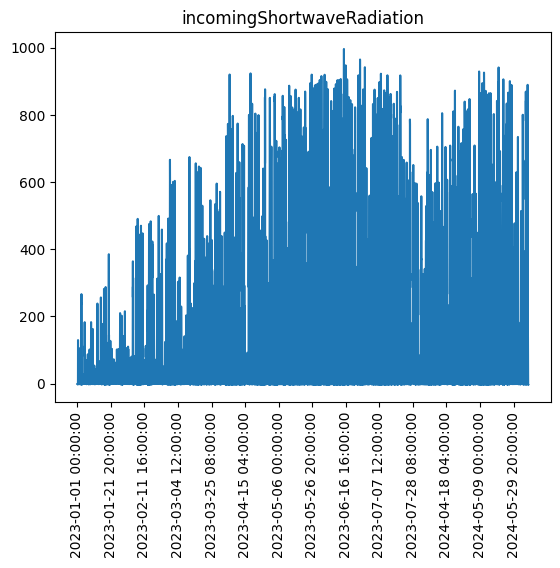

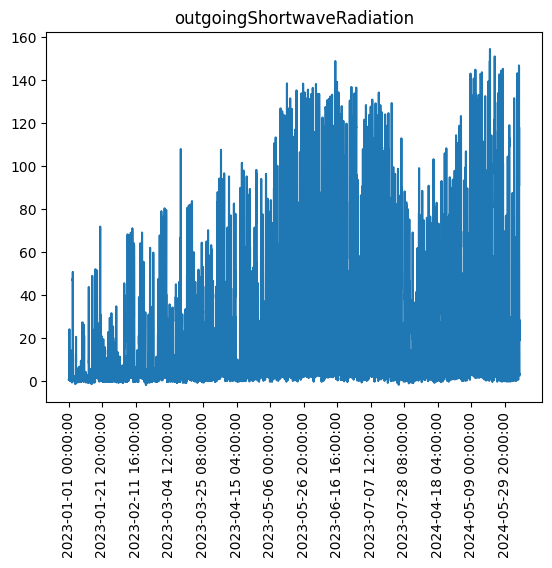

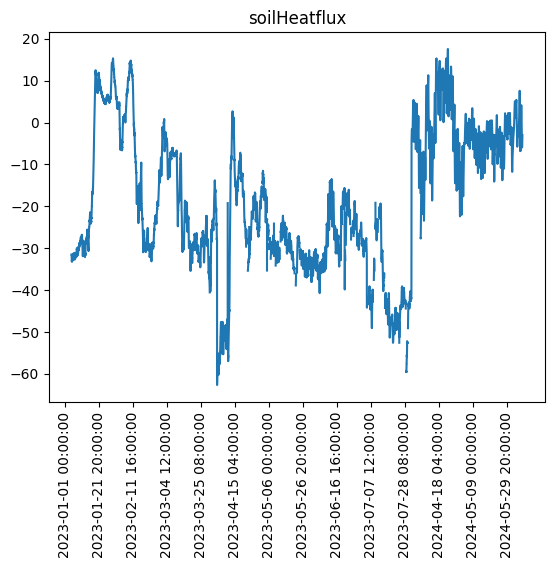

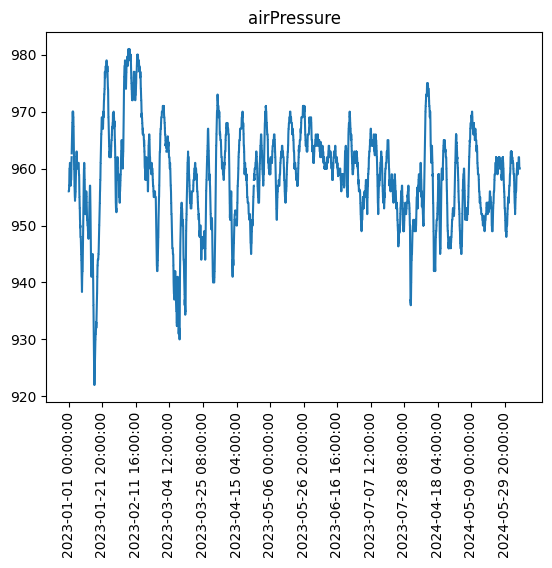

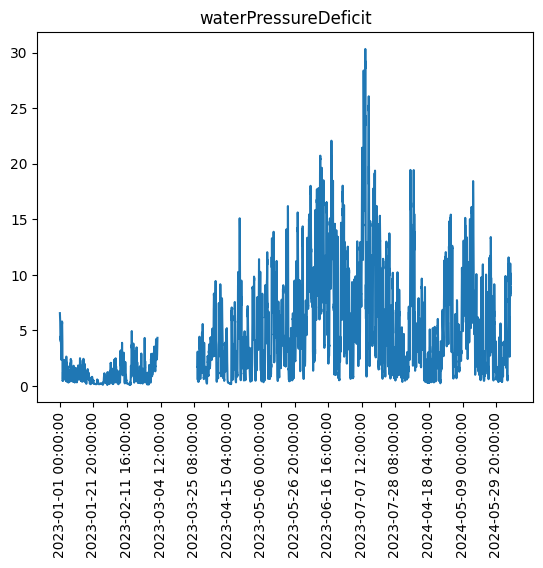

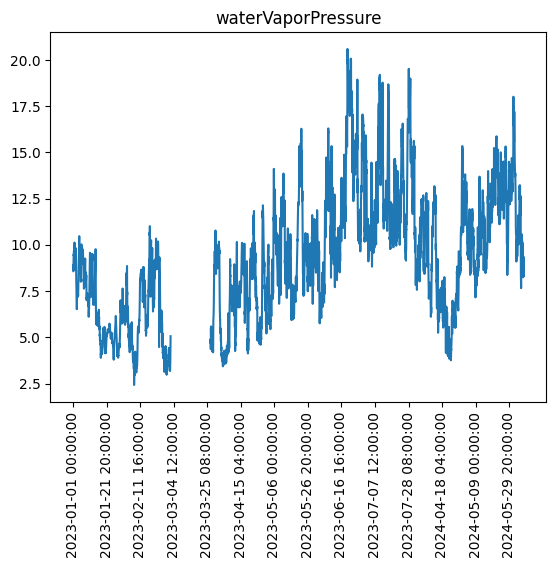

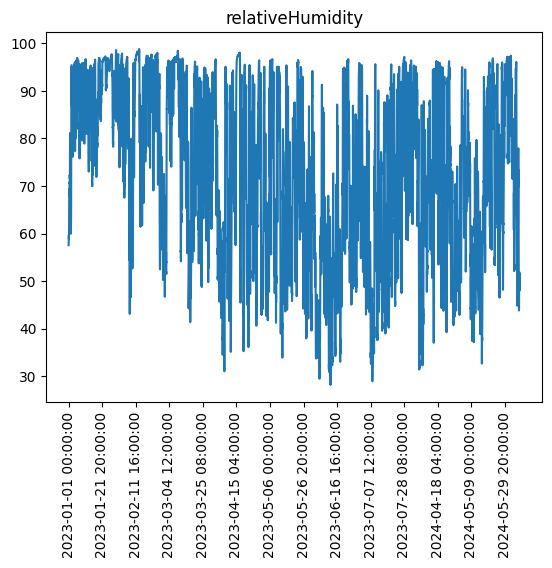

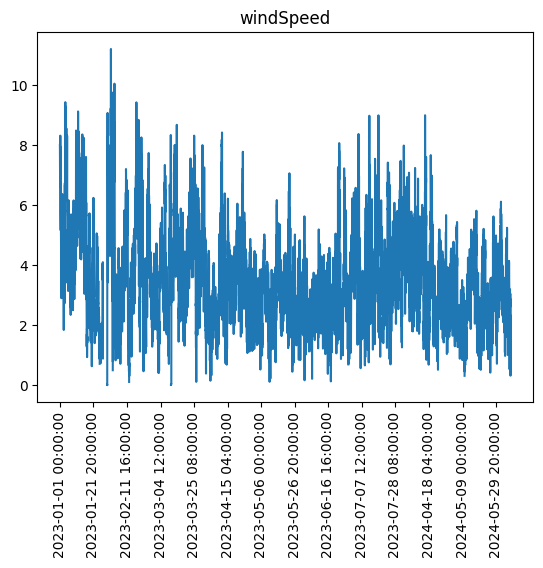

In [21]:
df_filtered = df[df["Location"] == 1]
cols_plot = [col for col in df_filtered.columns if col not in ["TIMESTAMP_START", "Location"]]
for col in cols_plot:
    plt.figure()
    plt.title(col)
    plt.plot(df_filtered["TIMESTAMP_START"], df_filtered[col])
    plt.xticks(df_filtered["TIMESTAMP_START"].unique()[::1000], rotation=90)
    plt.show()